In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### Loading the Images

In [2]:
# Classifying images
data = image_dataset_from_directory(
    "image_data/",
    batch_size=8,
    seed=42,
    class_names=("not_logos", "logos")
)

Found 650 files belonging to 2 classes.


### Converting to Dataset

In [3]:
# Sorting the data into image and label (X and y variables)
X = []
y = []

for idx, image in enumerate(data):
    try:
        batch_x, batch_y = image
        X.extend(batch_x)
        y.extend(batch_y)
    except Exception as e:
        print(f"Error loading batch {idx}: {str(e)}")

2024-07-17 03:32:32.911466: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
# number of images in total
len(X)

650

In [5]:
X[0].shape

TensorShape([256, 256, 3])

In [6]:
# Converting the X and y into array and the right shape for model
X = np.array(X)
y = np.array(y)

X = X.reshape(X.shape[0], -1)

In [7]:
# Checking the count of not_logos (0) and logos (1) in dataset
np.unique(y, return_counts=True)

(array([0, 1], dtype=int32), array([433, 217]))

### Splitting the Dataset

In [8]:
# Splitting the datasets into train and test ones
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Overview of sizes of the different sets
print(f"training data size: {X_train.shape}, testing data size: {X_test.shape}")
print(f"training results size: {y_train.shape}, testing results size: {y_test.shape}")

training data size: (520, 196608), testing data size: (130, 196608)
training results size: (520,), testing results size: (130,)


In [10]:
# Checking the count of not_logos (0) and logos (1) in the testing dataset
np.unique(y_test, return_counts=True)

(array([0, 1], dtype=int32), array([88, 42]))

### Random Forest Classifier

In [11]:
# initialising a model
random_forest = RandomForestClassifier(random_state=42)

# Train the model
random_forest.fit(X_train, y_train)

# Predict on the test set
y_pred = random_forest.predict(X_test)

In [12]:
# Overview of the model
random_forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [13]:
# Get the depth of each tree in the forest
random_forest_max_depths = []
for tree in random_forest.estimators_:
    random_forest_max_depths.append(tree.tree_.max_depth)

# Get the min and max depth among all trees
min_depth = min(random_forest_max_depths)
max_depth = max(random_forest_max_depths)
print(f"Minimum depth of the trees in the random forest model: {min_depth}\
      \nMaximum depth of trees in the random forest: {max_depth}")

Minimum depth of the trees in the random forest model: 6      
Maximum depth of trees in the random forest: 13


### Hyperparameter Tuning

In [14]:
# Hyperparameter tuning using GridSearchCV
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    "max_depth": range(7, 11),
    "n_estimators": [150, 200, 250]
    # "min_samples_split": [2, 3, 4]
    }

# Initialize GridSearchCV and fit it to the training data
grid_search = GridSearchCV(random_forest, param_grid, n_jobs=-1, scoring="accuracy", cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(7, 11),
                         'n_estimators': [150, 200, 250]},
             scoring='accuracy')

In [15]:
# Checking the best parameters
print(f"Best parameters for Random Forest: {grid_search.best_params_}")
print(f"Best cross-validated accuracy for Random Forest: {round((grid_search.best_score_)*100, 2)}%")

Best parameters for Random Forest: {'max_depth': 7, 'n_estimators': 200}
Best cross-validated accuracy for Random Forest: 88.08%


In [16]:
# Train the model with tuned max_depths
random_forest_tuned = RandomForestClassifier(**grid_search.best_params_, random_state=42)
random_forest_tuned.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, n_estimators=200, random_state=42)

In [17]:
# Getting an array of scores for each image prediction
y_pred_scores = random_forest_tuned.predict_proba(X_test)[:, 1]

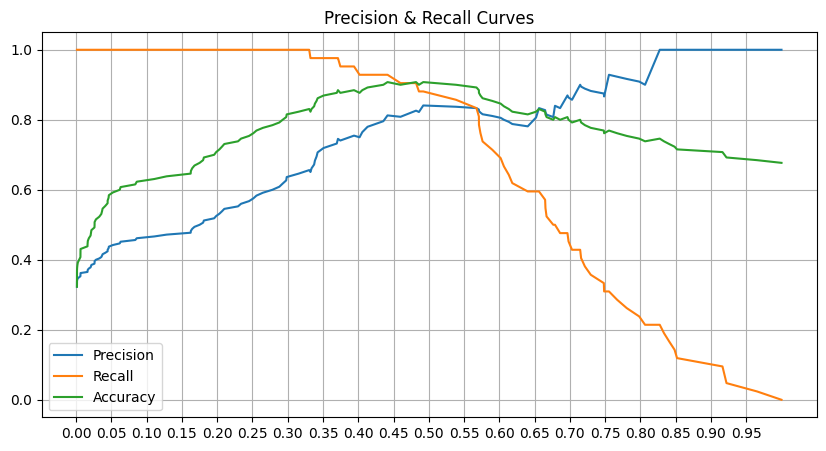

In [18]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_scores)

thresholds = np.append(thresholds, 1) # Adding a threshold to match precision and recall lengths

accuracies = [accuracy_score(y_test, y_pred_scores >= t) for t in thresholds]

# Plotting the precision-recall and accuracy curve
plt.figure(figsize=(10, 5))
plt.plot(thresholds, precision, label=f'Precision')
plt.plot(thresholds, recall, label=f'Recall')
plt.plot(thresholds, accuracies, label="Accuracy")
plt.title('Precision & Recall Curves')
plt.grid(True)
plt.legend(loc="best")
plt.xticks(np.arange(0, 1, 0.05))
plt.show()

In [19]:
# Predict using the tuned random forest on the test set, also setting the threshold
y_pred_tuned = (random_forest_tuned.predict_proba(X_test)[:, 1] >= 0.48)

### Confusion Matrix

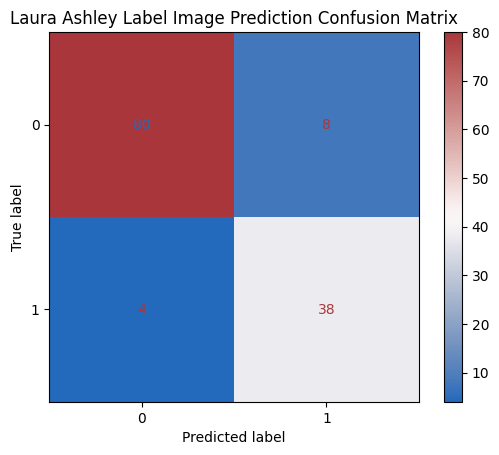

In [20]:
# Creating a Confusion Matrix
cm = confusion_matrix(y_test, y_pred_tuned)
cm_diagram = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_diagram.plot(cmap="vlag")
plt.title("Laura Ashley Label Image Prediction Confusion Matrix")
plt.show()

In [21]:
# Taking a look at the predictions of wrong image by getting their index position
wrong_img = np.where(y_pred_tuned != y_test)
fig_num = int(sum(len(array) for array in wrong_img))
fig_num

12

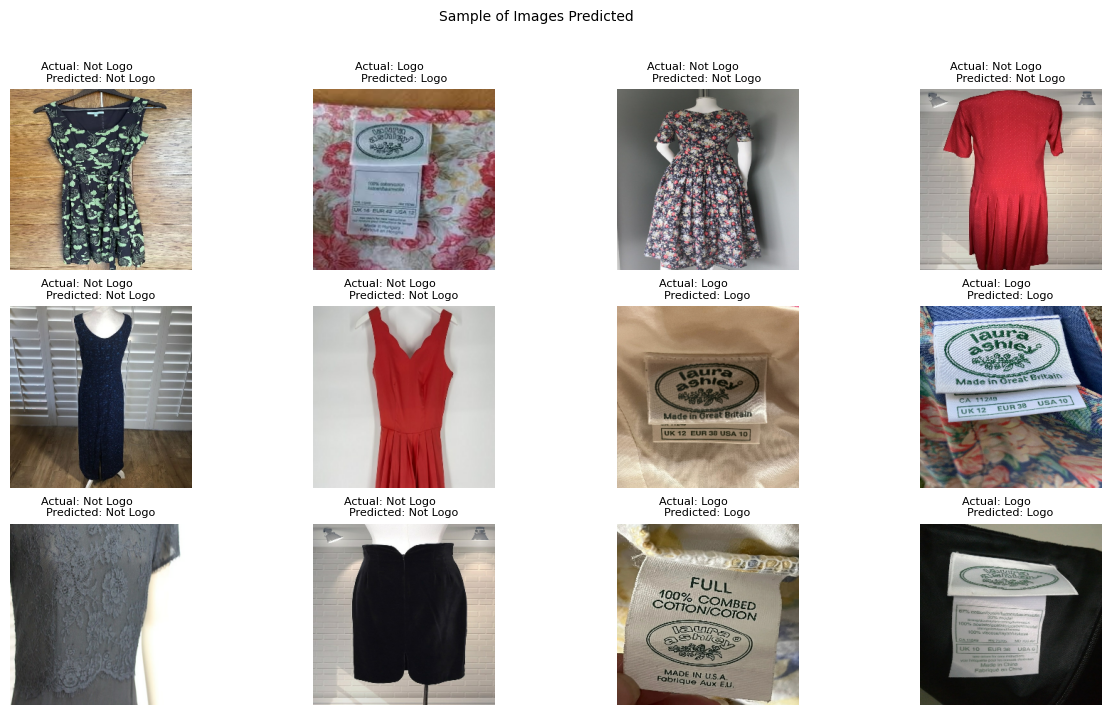

In [22]:
plt.figure(figsize=(15,8))
for i in range(fig_num):
    plt.subplot(3, 4, i+1)
    plt.imshow(np.reshape(X_test[i], (256, 256, 3)).astype(np.uint8))
    plt.axis("off")
    plt.title(f"Actual: {'Logo' if y_test[i]==1 else 'Not Logo'}\
        \nPredicted: {'Logo' if y_pred_tuned[i]==1 else 'Not Logo'}", fontsize=8)

# Titles
plt.suptitle("Sample of Images Predicted", fontsize=10)
plt.show()

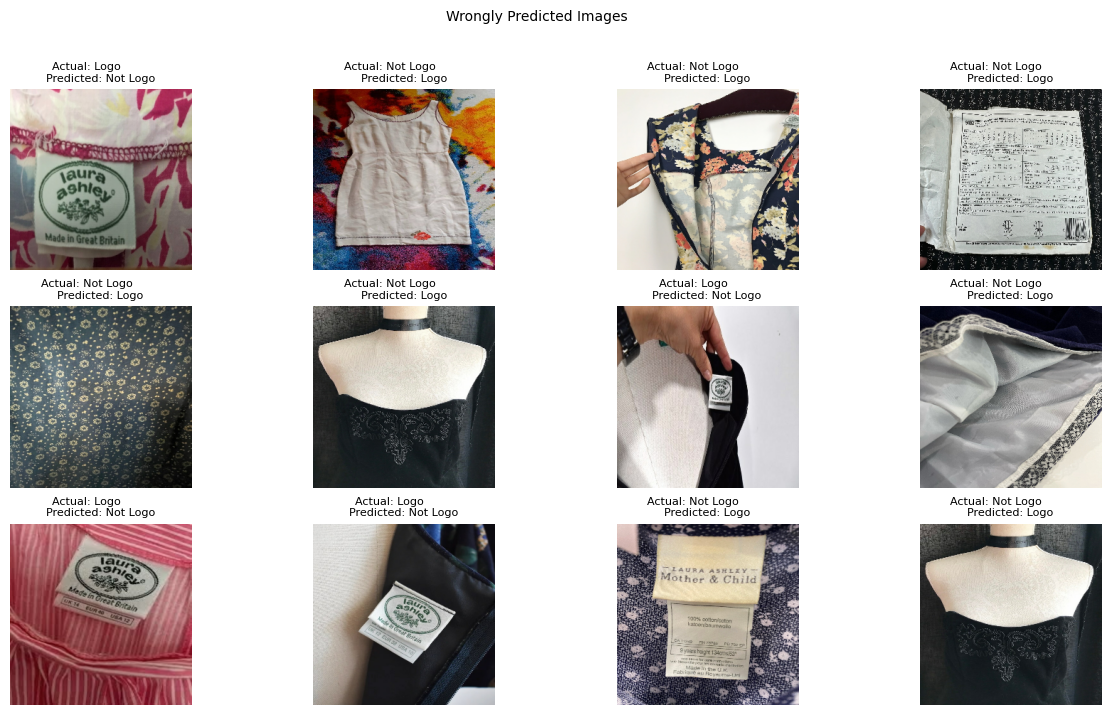

In [23]:
# Plotting the wrongly-predicted images 
plt.figure(figsize=(15,8))
for index, (image, label, predict) in enumerate(zip(X_test[wrong_img], y_test[wrong_img], y_pred_tuned[wrong_img])):
    plt.subplot(3, int(np.ceil(fig_num/3)), index + 1)
    plt.imshow(np.reshape(image, (256, 256, 3)).astype(np.uint8))
    plt.axis("off")
    plt.title(f"Actual: {'Logo' if label==1 else 'Not Logo'}\
        \nPredicted: {'Logo' if predict==1 else 'Not Logo'}", fontsize=8)
# Titles
plt.suptitle("Wrongly Predicted Images", fontsize=10)
plt.show()

### Model Performance Evaluation

In [24]:
# Calculating the evaluation scores
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc_score = accuracy_score(y_test, y_pred_tuned)
pre_score = precision_score(y_test, y_pred_tuned, average="macro")
rec_score = recall_score(y_test, y_pred_tuned, average="macro")
fone_score = f1_score(y_test, y_pred_tuned, average="macro")

print(f"Accuracy Score: {round(acc_score*100, 2)}%,\
      \nPrecision Score: {round(pre_score*100, 2)}%,\
      \nRecall Score: {round(rec_score*100, 2)}%,\
      \nF1 Score: {round(fone_score*100, 2)}%")

Accuracy Score: 90.77%,      
Precision Score: 88.92%,      
Recall Score: 90.69%,      
F1 Score: 89.69%


In [25]:
# Save the trained model to a file
import pickle

with open("src/logo_identifier.pkl", "wb") as file:
    pickle.dump(random_forest_tuned, file)